# **Reinforcement Learning: Mountain Car**


**(a) Description of the MountainCar Environment**

The MountainCar-v0 (MDP) environment consists of a car located stochastically at the bottom of a sinusoidal valley with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill.

There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. In the simplified Gym version, this is captured through a reduced state and action space.The underlying physics can be understood as a car moving in a one-dimensional valley, where the agent must convert kinetic energy into potential energy to reach the goal.

**State variables**

In reinforcement learning, the state is defined as the set of information that an agent has about the environment at a given time. The state in MountainCar-v0 is always continuous and is given by

st = (xt, ˙xt),

where xt is the horizontal position and ˙xt is the velocity of the car. These two variables describe the car’s current state. The agent uses this information to select an appropriate action at each time step.

**Action Space**

The Mountain Car environment can have a discrete or continuous action space:

• Discrete action (MountainCar-v0): three deterministic actions
1. 0: accelerate to the left,
2. 1: do not accelerate,
3. 2: accelerate to the right.

• Continuous action (MountainCarContinuous-v0):a single real-valued action representing the directional force applied to the car.

**Reward Function**
The goal of the agent is to reach the flag placed on top of the right hill as quickly as possible. To encourage this, the agent receives a negative reward at each time step until it reaches the goal as quickly and efficiently as possible. The episode ends when the goal is reached or when a maximum number of steps is exceeded.

**Physical interpretation.**

Because the engine is not strong enough to climb the right hill directly, the car must first drive back and forth, increasing its kinetic energy on downhill segments and converting it into potential energy when climbing. Optimal control requires building sufficient mo- mentum and its done by the agent exploiting the terrain: building momentum in the valley and timing accelerations so that enough energy is accumulated to reach the top of the hill.

In this code, we are using the Discrete action.



**(b) Implementing a neural network policy πθ(a|s) with parameters θ, mapping state vectors s
to action probabilities using a softmax output layer.**

In [114]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [115]:
#Set up the Mountain car-v0 environment
env = gym.make("MountainCar-v0", render_mode="rgb_array")

state_dim = 2        # position,velocity
action_dim = env.action_space.n  # 3 discrete actions: left, no push, right

print(f"State dimension: {state_dim}, Action dimension: {action_dim}")

State dimension: 2, Action dimension: 3


In [116]:
class PolicyNetwork(nn.Module):
    def __init__(self, state_dim, action_dim, hidden_dim=128):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(state_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, action_dim),
            nn.Softmax(dim=-1)  # Output probabilities for actions
        )

    def forward(self, state):
        return self.fc(state)

In [117]:
def select_action(policy, state):
    state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
    action_probs = policy(state).squeeze(0)
    action_dist = torch.distributions.Categorical(probs=action_probs)
    action = action_dist.sample()
    return action.item(), action_dist.log_prob(action)

In [118]:
# Initialize policy network
policy = PolicyNetwork(state_dim, action_dim)

# Text action sampling
dummy_state = np.array([-0.5, 0.0], dtype=np.float32)
action, log_prob = select_action(policy,dummy_state)
print(f"Sampled action: {action}, Log-probability: {log_prob.item()}")

Sampled action: 2, Log-probability: -1.122199535369873


In [119]:
def collect_trajectory(policy, env, max_steps=500):
    states, actions, log_probs, rewards = [], [], [], []
    state, _ = env.reset()
    state = np.array([np.random.uniform(-0.6, -0.4), 0.0], dtype=np.float32)

    # The trajectory can be max_steps long
    for _ in range(max_steps):

        # For EACH step, we want to store the action and log( pi(a|s) )
        action, log_prob = select_action(policy, state)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        # Reward shaping for MountainCar
        position, velocity = state
        if position >= 0.5:  # goal
            reward += 100.0
        reward += (position + 0.5) * 10
        reward += (velocity ** 2) * 50.0
        if 0.3 < position < 0.5:
            reward += (position - 0.3) * 20.0

        #Store data
        states.append(state)
        actions.append(action)
        log_probs.append(log_prob)
        rewards.append(reward)

        if done:
            break

        # Prepare state for next iteration of for loop
        state = next_state

    return states, actions, log_probs, rewards


In [120]:
def compute_returns(rewards, gamma=0.99):
    returns = []
    G = 0
    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)  #Insert at the beginning
    returns = np.array(returns)
    if len(returns) > 1:
        returns = (returns - returns.mean()) / (returns.std() + 1e-8)
    return returns.tolist()

In [121]:
optimizer = optim.Adam(policy.parameters())
def reinforce_update(policy, optimizer, states, actions, returns):
    states_tensor = torch.tensor(np.array(states), dtype=torch.float32)
    actions_tensor = torch.tensor(actions, dtype=torch.int64)
    returns_tensor = torch.tensor(returns, dtype=torch.float32)

    # normalize returns
    returns_tensor = (returns_tensor - returns_tensor.mean()) / (returns_tensor.std() + 1e-8)

    probs = policy(states_tensor)
    dist = torch.distributions.Categorical(probs)
    log_probs = dist.log_prob(actions_tensor)

    # Standard REINFORCE loss
    loss = -(log_probs * returns_tensor).sum()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return returns_tensor.mean().item()


**(c) Train your agent and plot the average return per
episode.**

Episode   50 | Average return (last 50): -229.9
Episode  100 | Average return (last 50): -190.1
Episode  150 | Average return (last 50): -146.7
Episode  200 | Average return (last 50): -82.5
Episode  250 | Average return (last 50): -3.3
Episode  300 | Average return (last 50): 37.0
Episode  350 | Average return (last 50): 40.1
Episode  400 | Average return (last 50): 44.7
Episode  450 | Average return (last 50): 44.2
Episode  500 | Average return (last 50): 46.2
Episode  550 | Average return (last 50): 44.9
Episode  600 | Average return (last 50): 49.8
Episode  650 | Average return (last 50): 47.0
Episode  700 | Average return (last 50): 43.8
Episode  750 | Average return (last 50): 47.0
Episode  800 | Average return (last 50): 44.0
Episode  850 | Average return (last 50): 44.6
Episode  900 | Average return (last 50): 45.6
Episode  950 | Average return (last 50): 48.2
Episode 1000 | Average return (last 50): 46.1


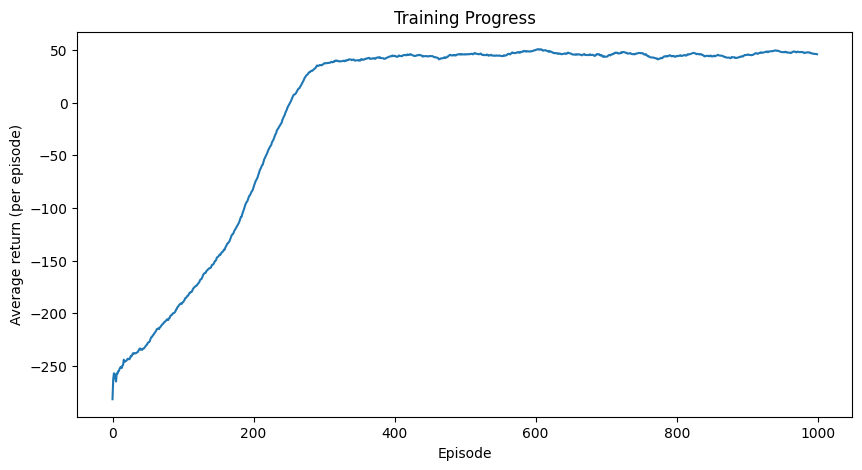

In [122]:
#Training loop
def main():
    num_episodes = 1000
    batch_size = 4
    episode_rewards = []

    buffer_states, buffer_actions, buffer_returns = [], [], []

    for episode in range(num_episodes):
        states, actions, log_probs, rewards = collect_trajectory(policy, env)
        returns = compute_returns(rewards)
        buffer_states.extend(states)
        buffer_actions.extend(actions)
        buffer_returns.extend(returns)
        episode_rewards.append(sum(rewards))

        if (episode + 1) % batch_size == 0:
            reinforce_update(policy, optimizer, buffer_states, buffer_actions, buffer_returns)
            buffer_states, buffer_actions, buffer_returns = [], [], []

        if (episode + 1) % 50 == 0:
            avg_return = np.mean(episode_rewards[-50:])
            print(f"Episode {episode+1:4d} | Average return (last 50): {avg_return:.1f}")

    # Plot average return per episode
    moving_avg = [np.mean(episode_rewards[max(0, i-49):i+1]) for i in range(len(episode_rewards))]
    plt.figure(figsize=(10,5))
    plt.plot(moving_avg)
    plt.xlabel("Episode")
    plt.ylabel("Average return (per episode)")
    plt.title("Training Progress")
    plt.show()

    env.close()


if __name__ == "__main__":
    main()


**Observations**

 From the output we can see the agent learns to solve the MountainCar-v0 after some time. Initially the average return(per episode) is negative, showing the agent is failing to reach the goal. As training goes on, the returns increase, becoming positive approx. around episode 250–350. By episode 500–600, the agent  achieves the goal consistently which can be seen by the stable average returns in the later episodes. This shows that the agent successfully learns the optimal policy to reach the target position with the plotted average return per episode showing this learning.

**(d) Physical Interpretation**

The MountainCar-v0 environment is an interpretation of a car which must climb a steep hill but lacks the power to go directly upward. It must first drive back and forth, converting kinetic energy into potential energy. The agent learns to “pump” energy by firstly it moves away from the goal to climb the opposite slope and stores potential energy, then it goes down  and converts the potential energy into kinetic energy and gain speed and momentum. By repeating this motion, it builds enough kinetic energy to reach the top. By pushing at the right times, the agent performs work on the car, gradually increasing its total energy.The agent learned behavior is a strategy to times its actions to maximize work done on the car.


